In [ ]:
# 1 task
import time
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from transformers import create_optimizer

# 1. Dataset
def load_data():
    dataset = load_dataset("ag_news")
    train_texts = dataset["train"]["text"][:5000]
    train_labels = dataset["train"]["label"][:5000]
    test_texts = dataset["test"]["text"][:1000]
    test_labels = dataset["test"]["label"][:1000]
    
    
    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    
    return train_texts, test_texts, y_train, y_test

# 2. RNN
def build_and_train_rnn(train_texts, test_texts, y_train, y_test):
    max_len = 100
    vocab_size = 10000
    embedding_dim = 64
    lstm_units = 64
    batch_size = 64
    epochs = 3
    
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts)
    
    X_train = pad_sequences(
        tokenizer.texts_to_sequences(train_texts),
        maxlen=max_len,
        padding="post"
    )
    X_test = pad_sequences(
        tokenizer.texts_to_sequences(test_texts),
        maxlen=max_len,
        padding="post"
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.LSTM(lstm_units),
        tf.keras.layers.Dense(lstm_units, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')  
    ])
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    print("\nTraining RNN model...")
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )
    training_time = time.time() - start_time
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time

# 3. Transformer
def build_and_train_bert(train_texts, test_texts, y_train, y_test):
    model_name = "distilbert-base-uncased"
    batch_size = 32
    epochs = 3
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
    
    train_encodings = tokenizer(
        train_texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="tf"
    )
    test_encodings = tokenizer(
        test_texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="tf"
    )
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
    )).batch(batch_size)
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        y_test
    )).batch(batch_size)
    
    optimizer, _ = create_optimizer(
        init_lr=2e-5,
        num_train_steps=len(train_dataset) * epochs,
        num_warmup_steps=100,
    )
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["accuracy"]
    )
    
    print("\nTraining BERT model...")
    start_time = time.time()
    history = model.fit(
        train_dataset,
        epochs=epochs,
        verbose=1
    )
    training_time = time.time() - start_time
    
    y_pred = np.argmax(model.predict(test_dataset).logits, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time

def main():
    train_texts, test_texts, y_train, y_test = load_data()
    
    # RNN training and evaluation
    rnn_acc, rnn_time = build_and_train_rnn(train_texts, test_texts, y_train, y_test)
    print(f"\nRNN Results - Accuracy: {rnn_acc:.4f}, Training Time: {rnn_time:.2f} sec")
    
    # Bert training and evaluation
    bert_acc, bert_time = build_and_train_bert(train_texts, test_texts, y_train, y_test)
    print(f"\nBERT Results - Accuracy: {bert_acc:.4f}, Training Time: {bert_time:.2f} sec")
    
    # Comparison
    print(f"RNN:  Accuracy = {rnn_acc:.4f} | Time = {rnn_time:.2f} sec")
    print(f"BERT: Accuracy = {bert_acc:.4f} | Time = {bert_time:.2f} sec")
    print("="*30)

if __name__ == "__main__":
    main()


Training RNN model...
Epoch 1/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3108 - loss: 1.3767 - val_accuracy: 0.1880 - val_loss: 1.4032
Epoch 2/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3156 - loss: 1.3752 - val_accuracy: 0.1880 - val_loss: 1.4147
Epoch 3/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3156 - loss: 1.3738 - val_accuracy: 0.1880 - val_loss: 1.4084
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

RNN Results - Accuracy: 0.2530, Training Time: 10.08 sec


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 


Training BERT model...
Epoch 1/3


157/157 [==============================] - 868s 5s/step - loss: 0.8747 - accuracy: 0.6586
Epoch 2/3
157/157 [==============================] - 777s 5s/step - loss: 0.3934 - accuracy: 0.8834
Epoch 3/3
32/32 [==============================] - 46s 1s/step

BERT Results - Accuracy: 0.9020, Training Time: 2353.99 sec

===== FINAL COMPARISON =====
RNN:  Accuracy = 0.2530 | Time = 10.08 sec
BERT: Accuracy = 0.9020 | Time = 2353.99 sec


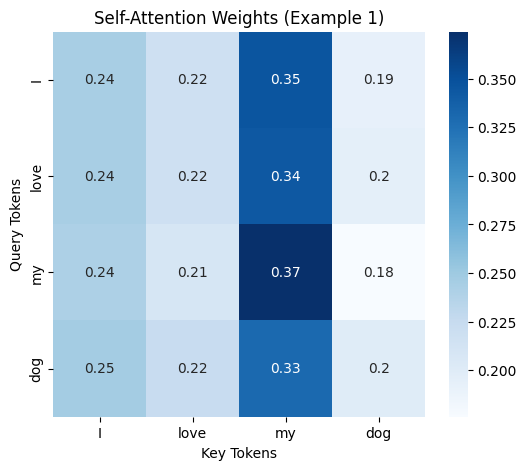

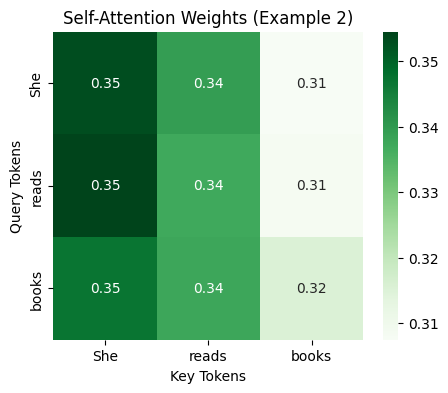

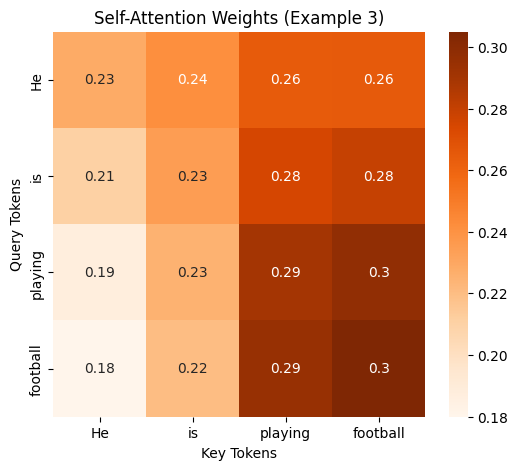

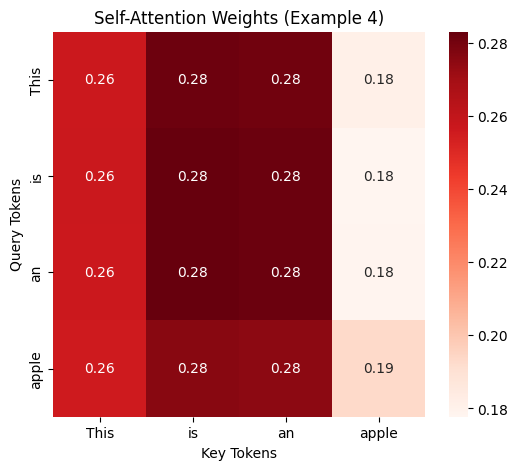

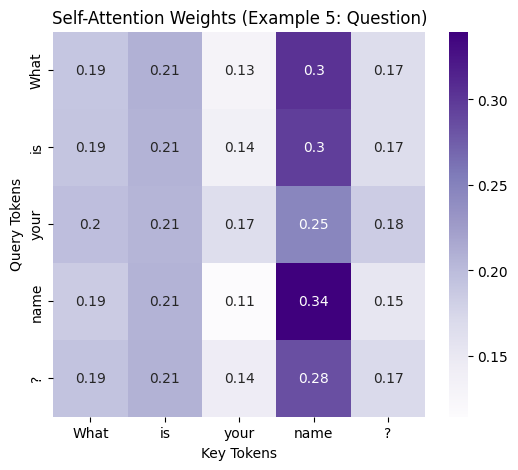

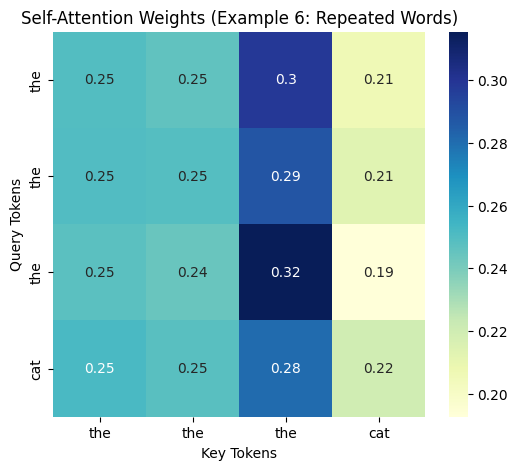

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Softmax
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

# Self-attention function
def self_attention(X):
    d_k = X.shape[1]
    W_q = np.random.rand(d_k, d_k)
    W_k = np.random.rand(d_k, d_k)
    W_v = np.random.rand(d_k, d_k)
    
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v
    
    scores = Q @ K.T / np.sqrt(d_k)
    attention_weights = softmax(scores)
    output = attention_weights @ V
    return attention_weights, output

np.random.seed(0)

# Example 1
tokens1 = ['I', 'love', 'my', 'dog']
X1 = np.random.rand(len(tokens1), 3)
attn1, out1 = self_attention(X1)

plt.figure(figsize=(6, 5))
sns.heatmap(attn1, xticklabels=tokens1, yticklabels=tokens1, annot=True, cmap="Blues")
plt.title("Self-Attention Weights (Example 1)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Example 2
tokens2 = ['She', 'reads', 'books']
X2 = np.random.rand(len(tokens2), 3)
attn2, out2 = self_attention(X2)

plt.figure(figsize=(5, 4))
sns.heatmap(attn2, xticklabels=tokens2, yticklabels=tokens2, annot=True, cmap="Greens")
plt.title("Self-Attention Weights (Example 2)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Example 3
tokens3 = ['He', 'is', 'playing', 'football']
X3 = np.random.rand(len(tokens3), 3)
attn3, out3 = self_attention(X3)

plt.figure(figsize=(6, 5))
sns.heatmap(attn3, xticklabels=tokens3, yticklabels=tokens3, annot=True, cmap="Oranges")
plt.title("Self-Attention Weights (Example 3)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Example 4
tokens4 = ['This', 'is', 'an', 'apple']
X4 = np.random.rand(len(tokens4), 3)
attn4, out4 = self_attention(X4)

plt.figure(figsize=(6, 5))
sns.heatmap(attn4, xticklabels=tokens4, yticklabels=tokens4, annot=True, cmap="Reds")
plt.title("Self-Attention Weights (Example 4)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Example 5
tokens5 = ['What', 'is', 'your', 'name', '?']
X5 = np.random.rand(len(tokens5), 3)
attn5, out5 = self_attention(X5)

plt.figure(figsize=(6, 5))
sns.heatmap(attn5, xticklabels=tokens5, yticklabels=tokens5, annot=True, cmap="Purples")
plt.title("Self-Attention Weights (Example 5: Question)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Example 6
tokens6 = ['the', 'the', 'the', 'cat']
X6 = np.random.rand(len(tokens6), 3)
attn6, out6 = self_attention(X6)

plt.figure(figsize=(6, 5))
sns.heatmap(attn6, xticklabels=tokens6, yticklabels=tokens6, annot=True, cmap="YlGnBu")
plt.title("Self-Attention Weights (Example 6: Repeated Words)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


Epoch 1/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.5165 - loss: 0.7181 - val_accuracy: 0.4940 - val_loss: 0.7013
Epoch 2/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.5123 - loss: 0.7003 - val_accuracy: 0.5060 - val_loss: 0.6971
Epoch 3/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.5227 - loss: 0.6933 - val_accuracy: 0.6800 - val_loss: 0.6067
Epoch 4/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.7669 - loss: 0.4966 - val_accuracy: 0.8340 - val_loss: 0.4116
Epoch 5/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9220 - loss: 0.2169 - val_accuracy: 0.8340 - val_loss: 0.4328
Epoch 6/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9651 - loss: 0.1070 - val_accuracy: 0.7980 - val_loss: 0.5975
Epoch 7/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9855 - loss: 0.0518 - val_accuracy: 0.7880 - val_loss: 0.8887
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8383 - loss: 0.7202
Test Accuracy: 0.8215


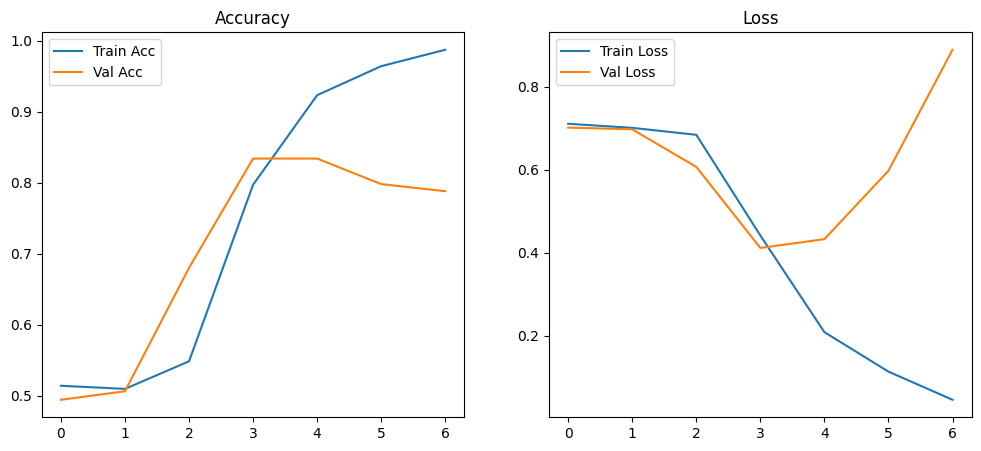

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load IMDb dataset
def load_imdb_data(vocab_size=10000, maxlen=200, train_samples=5000, test_samples=2000):
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
    X_train = X_train[:train_samples]
    y_train = y_train[:train_samples]
    X_test = X_test[:test_samples]
    y_test = y_test[:test_samples]
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    return (X_train, y_train), (X_test, y_test)

# Positional Encoding
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, attention_mask=None, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer model
def build_transformer_model(vocab_size, seq_len, d_model, num_heads, dff):
    inputs = tf.keras.Input(shape=(seq_len,))
    x = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    x += get_positional_encoding(seq_len, d_model)
    x = TransformerBlock(d_model, num_heads, dff)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Training and evaluation
def train_and_evaluate():
    vocab_size = 10000
    seq_len = 200
    d_model = 64
    num_heads = 4
    dff = 128
    batch_size = 64
    epochs = 7

    (X_train, y_train), (X_test, y_test) = load_imdb_data(vocab_size, seq_len)
    model = build_transformer_model(vocab_size, seq_len, d_model, num_heads, dff)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs)
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    train_and_evaluate()


In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Load and sample dataset
dataset = load_dataset("imdb")
train_data = dataset["train"].shuffle(seed=42).select(range(500))  
test_data = dataset["test"].shuffle(seed=42).select(range(100))    

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Training
training_args = TrainingArguments(
    output_dir="./bert-imdb",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

# Fine-tune BERT
trainer.train()

# Evaluate on test set
results = trainer.evaluate()
print("\nEvaluation results:", results)

# Inference: text classification examples
def classify(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
        prediction = torch.argmax(output.logits, dim=1).item()
    label = "positive" if prediction == 1 else "negative"
    return label

# Sample predictions
examples = [
    "I absolutely loved this movie. It was fantastic!",
    "Terrible plot and bad acting. I hated it.",
    "It was okay, some parts were good, others not so much."
]

print("\nText classification examples:")
for i, example in enumerate(examples, 1):
    print(f"Example {i}: {classify(example)} — \"{example}\"")


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.381600,0.306477,0.880000
2,0.143600,0.290724,0.900000



Evaluation results: {'eval_loss': 0.2907238304615021, 'eval_accuracy': 0.9, 'eval_runtime': 46.2036, 'eval_samples_per_second': 2.164, 'eval_steps_per_second': 0.281, 'epoch': 2.0}

Text classification examples:
Example 1: positive — "I absolutely loved this movie. It was fantastic!"
Example 2: negative — "Terrible plot and bad acting. I hated it."
Example 3: positive — "It was okay, some parts were good, others not so much."


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# Input prompt
prompt = "A long time ago, in a galaxy far, far away"
inputs = tokenizer(prompt, return_tensors="pt", padding=True)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Generate text
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=100,
    num_return_sequences=1,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.9,
    pad_token_id=tokenizer.pad_token_id
)

# Decode and print
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)


A long time ago, in a galaxy far, far away, a new civilization arose. It was the Space Marines. Their powers were immense, to be reckoned with. The marines had no way of getting close enough, so they decided to turn to a military force.

Their tactics were well thought out, even the basic combat skills were developed and perfected. It was a military force with many specialized weapons. A few units were armed with bayonets or gunships, which was all.


In [4]:
from transformers import MarianTokenizer, MarianMTModel

model_name = "Helsinki-NLP/opus-mt-en-ru"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

text = "Natural language processing (NLP) is a subfield of computer science and especially artificial intelligence. It is primarily concerned with providing computers with the ability to process data encoded in natural language and is thus closely related to information retrieval, knowledge representation and computational linguistics, a subfield of linguistics."
inputs = tokenizer(text, return_tensors="pt", padding=True)

translated = model.generate(**inputs, max_length=50)
print(tokenizer.decode(translated[0], skip_special_tokens=True))


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Обработка естественных языков (NLP) является субполицией компьютерной науки и особенно искусственного интеллекта, которая в первую очередь направлена на то, чтобы предоставить компьютерам возможность обрабатывать данные, кодируемые на естественном языке,


In [ ]:
# 1. NER and POS with spaCy
import spacy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nlp = spacy.load("en_core_web_sm")
text = "Apple is looking at buying U.K. startup for $1 billion"
doc = nlp(text)

print("== spaCy NER Results ==")
spacy_ents = [(ent.text, ent.label_) for ent in doc.ents]
for text_, label in spacy_ents:
    print(f"{text_:20} -> {label}")

print("\n== spaCy POS Tagging ==")
spacy_pos = [(token.text, token.pos_) for token in doc]
for word, pos in spacy_pos:
    print(f"{word:15} -> {pos}")

# 2. NER with Transformers (BERT)
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

model_name_ner = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer_ner = AutoTokenizer.from_pretrained(model_name_ner)
model_ner = AutoModelForTokenClassification.from_pretrained(model_name_ner)

ner_pipeline = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner, grouped_entities=True)
ner_results = ner_pipeline(text)

print("\n== Transformers NER Results ==")
bert_ents = [(ent['word'], ent['entity_group']) for ent in ner_results]
for word, label in bert_ents:
    print(f"{word:20} -> {label}")

# 3. POS Tagging with Transformers
from transformers import TokenClassificationPipeline

model_name_pos = "vblagoje/bert-english-uncased-finetuned-pos"
tokenizer_pos = AutoTokenizer.from_pretrained(model_name_pos)
model_pos = AutoModelForTokenClassification.from_pretrained(model_name_pos)

pos_pipeline = TokenClassificationPipeline(
    model=model_pos,
    tokenizer=tokenizer_pos,
    task="token-classification",
    aggregation_strategy="simple"
)

pos_results = pos_pipeline(text)
bert_pos = [(token['word'], token['entity_group']) for token in pos_results]

print("\n== Transformers POS Tagging ==")
for word, pos in bert_pos:
    print(f"{word:15} -> {pos}")

spacy_words = [word for word, _ in spacy_pos]
bert_words = [word for word, _ in bert_pos]
min_len = min(len(spacy_words), len(bert_words))

spacy_tags = [pos for _, pos in spacy_pos][:min_len]
bert_tags = [pos for _, pos in bert_pos][:min_len]

print("\n== POS Tagging Metrics (BERT vs spaCy as reference) ==")
accuracy = accuracy_score(spacy_tags, bert_tags)
precision, recall, f1, _ = precision_recall_fscore_support(spacy_tags, bert_tags, average='macro')

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")



== spaCy NER Results ==
Apple                -> ORG
U.K.                 -> GPE
$1 billion           -> MONEY

== spaCy POS Tagging ==
Apple           -> PROPN
is              -> AUX
looking         -> VERB
at              -> ADP
buying          -> VERB
U.K.            -> PROPN
startup         -> VERB
for             -> ADP
$               -> SYM
1               -> NUM
billion         -> NUM


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn


== Transformers NER Results ==
Apple                -> ORG
U                    -> LOC
K                    -> LOC


Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



== Transformers POS Tagging ==
apple           -> PROPN
is              -> AUX
looking         -> VERB
at              -> SCONJ
buying          -> VERB
u               -> PROPN
.               -> PUNCT
k               -> PROPN
.               -> PUNCT
startup         -> NOUN
for             -> ADP
$               -> SYM
1 billion       -> NUM

== POS Tagging Metrics (BERT vs spaCy as reference) ==
Accuracy:  0.45
Precision: 0.30
Recall:    0.30
F1-score:  0.29


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from seqeval.metrics import precision_score, recall_score, f1_score
import numpy as np

dataset = load_dataset("conll2003")

small_train = dataset["train"].select(range(1000))
small_val = dataset["validation"].select(range(200))
small_test = dataset["test"].select(range(200))

label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=num_labels)

def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, padding=True, is_split_into_words=True)

    labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(batch["tokens"]))):
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(batch["ner_tags"][i][word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_train = small_train.map(tokenize_and_align_labels, batched=True, remove_columns=small_train.column_names)
tokenized_val = small_val.map(tokenize_and_align_labels, batched=True, remove_columns=small_val.column_names)
tokenized_test = small_test.map(tokenize_and_align_labels, batched=True, remove_columns=small_test.column_names)

training_args = TrainingArguments(
    output_dir="./bert-ner",
    evaluation_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",           
    logging_strategy="no",       
    report_to="none"              
)

data_collator = DataCollatorForTokenClassification(tokenizer)

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    true_predictions = []
    true_labels = []

    for pred, lab in zip(predictions, labels):
        pred_labels = []
        lab_labels = []
        for p_, l_ in zip(pred, lab):
            if l_ != -100:
                pred_labels.append(label_list[p_])
                lab_labels.append(label_list[l_])
        true_predictions.append(pred_labels)
        true_labels.append(lab_labels)

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

test_results = trainer.evaluate(tokenized_test)
print(test_results)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\1423407827.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.139885,0.832099,0.857506,0.844612


{'eval_loss': 0.11396560817956924, 'eval_precision': 0.9122807017543859, 'eval_recall': 0.8943488943488943, 'eval_f1': 0.903225806451613, 'eval_runtime': 19.7222, 'eval_samples_per_second': 10.141, 'eval_steps_per_second': 1.268, 'epoch': 1.0}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_16644\2603411583.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.289548,0.893000,0.889119


🔹 BERT Evaluation: {'eval_loss': 0.28954800963401794, 'eval_accuracy': 0.893, 'eval_f1': 0.8891191709844559, 'eval_runtime': 435.3802, 'eval_samples_per_second': 2.297, 'eval_steps_per_second': 0.287, 'epoch': 1.0}
🔸 LSTM Evaluation:
Accuracy: 0.488
F1-score: 0.6497948016415869


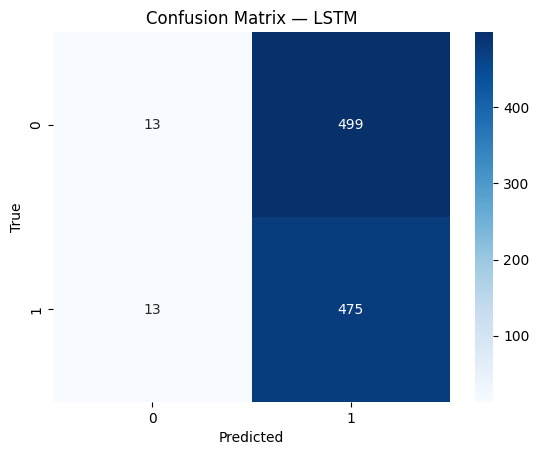

In [ ]:
# 1. Sentiment Analysis with BERT
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

# Load dataset
dataset = load_dataset("imdb")
small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

# Tokenization
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_train = small_train.map(tokenize, batched=True)
tokenized_test = small_test.map(tokenize, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-imdb",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
bert_eval = trainer.evaluate()
print("🔹 BERT Evaluation:", bert_eval)

# 2. Sentiment Analysis with LSTM (PyTorch)
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Simple tokenizer
def basic_tokenize(text):
    return text.lower().split()

# Vocabulary
counter = Counter()
for ex in small_train["text"]:
    counter.update(basic_tokenize(ex))
vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    return [vocab.get(w, 1) for w in basic_tokenize(text)]

class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = [torch.tensor(encode(t)) for t in texts]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

def collate_batch(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels)

train_ds = IMDBDataset(small_train["text"], small_train["label"])
test_ds = IMDBDataset(small_test["text"], small_test["label"])
train_dl = DataLoader(train_ds, batch_size=8, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=8, collate_fn=collate_batch)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm = LSTMClassifier(len(vocab)).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train LSTM
for epoch in range(1):
    model_lstm.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model_lstm(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

# Evaluate LSTM
model_lstm.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        out = model_lstm(x)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

print("🔸 LSTM Evaluation:")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1-score:", f1_score(all_labels, all_preds))

# Confusion Matrix for LSTM
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

dataset = load_dataset("imdb")
train_data = dataset["train"].shuffle(seed=42).select(range(500))   
test_data = dataset["test"].shuffle(seed=42).select(range(200))     

checkpoint = "distilbert-base-uncased"   
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tokenized_train = train_data.map(tokenize, batched=True)
tokenized_test = test_data.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./distilbert-finetuned-imdb",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,               
    learning_rate=5e-5,
    logging_steps=10,
    save_strategy="no",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate()
print("Evaluation Results:", results)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_8064\709301917.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.447700,0.439969,0.805000,0.739496,0.916667,0.818605
2,0.221300,0.377530,0.840000,0.863636,0.791667,0.826087


Evaluation Results: {'eval_loss': 0.37753021717071533, 'eval_accuracy': 0.84, 'eval_precision': 0.8636363636363636, 'eval_recall': 0.7916666666666666, 'eval_f1': 0.8260869565217391, 'eval_runtime': 45.5553, 'eval_samples_per_second': 4.39, 'eval_steps_per_second': 0.285, 'epoch': 2.0}
